# <center> Практика. 

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Данные содержат следующие столбцы:
*   work_year - Год, в котором была выплачена зарплата.
* experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
* employment_type - Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
* job_title - Роль, в которой соискатель работал в течение года.
* salary - Общая выплаченная валовая сумма заработной платы.
* salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio -Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
* company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).


Оригинальный датасет: “Data Science Job Salaries” (kaggle.com)

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

- Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## Загрузка данных

In [612]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.contingency_tables import mcnemar

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [613]:
# прочитаем датасет 
data_10_2 = pd.read_csv('C:\скил\DST-156\IDE_NEW\EDA-4. Статистические тесты\ds_salaries.csv', index_col=[0])
data_10_2.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [614]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [615]:
data_10_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений). В датасете 4 столбца (+1 с порядковым индексом строк) с числовыми и 7 с категориальными признаками 

Проверка данных на наличие полных дубликатов:

In [616]:
print('Количество дубликатов: {}'.format(data_10_2[data_10_2.duplicated()].shape[0]))

# Удаляем дубликаты:
data_10_2 = data_10_2.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data_10_2.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Так в датасете есть обобщающий признак заработной платы в USD (salary_in_usd), то очевидно, что размер зароботной платы в местной валюте и наименования валюты (столбы salary и salary_currency) для дальнейшего анализа нам не нужны. 

In [617]:
#удаляем стобцы salary и salary_currency
data_10_2 = data_10_2.drop(['salary','salary_currency'], axis= 1)
data_10_2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    int64 
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(3), object(6)
memory usage: 44.1+ KB


Поиск выбросов. При использовании метода describe() видно, что значения заробной платы имеют очень большую разбежку (от 2 859 до 600 000 USD). Причем максимальное значение зп "подозрительно" круглое. Ищем выбросы.   

In [618]:
data_10_2.describe()

,work_year,salary_in_usd,remote_ratio
count,565.000000,565.000000,565.000000
mean,2021.364602,110610.343363,69.911504
std,0.698138,72280.702792,40.900666
min,2020.000000,2859.000000,0.000000
25%,2021.000000,60757.000000,50.000000
50%,2021.000000,100000.000000,100.000000
75%,2022.000000,150000.000000,100.000000
max,2022.000000,600000.000000,100.000000


Строим график для поиска выбросов

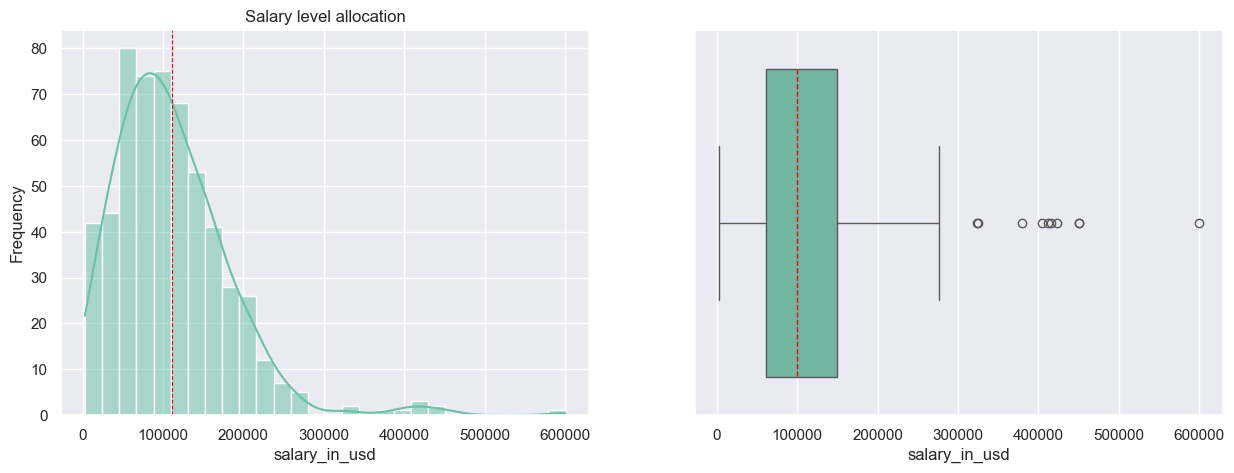

In [619]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_10_2['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='salary_in_usd', ylabel='Frequency')
axes[0].set_title('Salary level allocation')
axes[0].axvline(data_10_2['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data = data_10_2, x = 'salary_in_usd', orient='h', medianprops={"color": "red", "linestyle": '--'})

plt.show()

Распределение признака salary_in_usd не нормальное. Как видно из графика boxplot расброс значений основной заработной платы находится примерно до 300 000 usd. Все что более- удаляем. 

In [620]:
#убираем результаты с 3П более 300000
outliers = data_10_2[data_10_2['salary_in_usd']>300000]
cleaned_data_10_2 = data_10_2.drop(outliers.index, axis =0)
cleaned_data_10_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           555 non-null    int64 
 1   experience_level    555 non-null    object
 2   employment_type     555 non-null    object
 3   job_title           555 non-null    object
 4   salary_in_usd       555 non-null    int64 
 5   employee_residence  555 non-null    object
 6   remote_ratio        555 non-null    int64 
 7   company_location    555 non-null    object
 8   company_size        555 non-null    object
dtypes: int64(3), object(6)
memory usage: 43.4+ KB


In [621]:
data_agg_10_2 = cleaned_data_10_2['salary_in_usd'].describe().round(2).to_frame()
data_agg_10_2

,salary_in_usd
count,555.00
mean,105062.78
std,58981.19
min,2859.00
25%,60000.00
50%,100000.00
75%,145500.00
max,276000.00


Рассмотрим графика распределния уровня заработной платы после провеедения очистки от выбросов

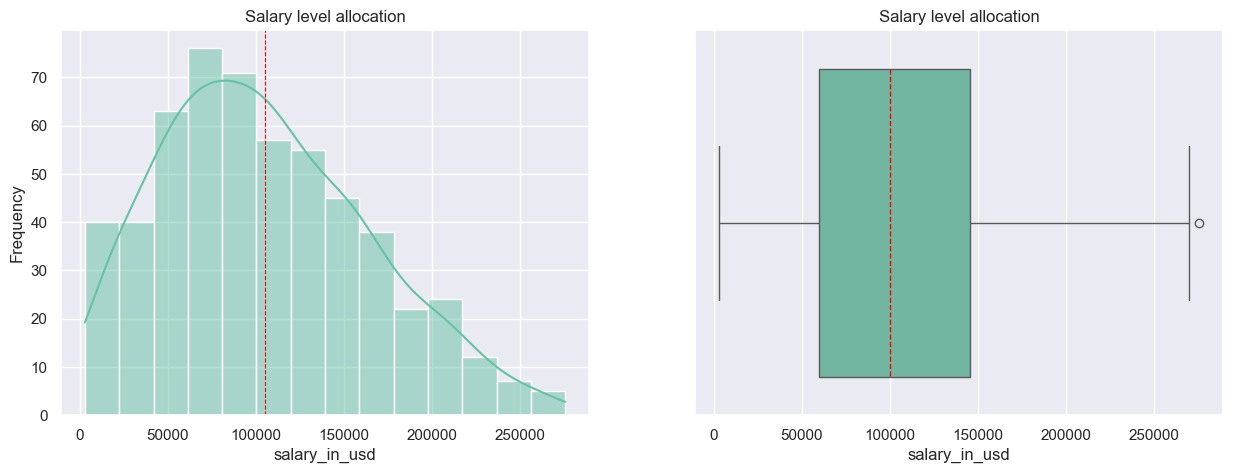

In [622]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(cleaned_data_10_2['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='salary_in_usd', ylabel='Frequency')
axes[0].set_title('Salary level allocation')
axes[0].axvline(cleaned_data_10_2['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

ax = sns.boxplot(cleaned_data_10_2, x='salary_in_usd', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='salary_in_usd')
plt.title('Salary level allocation')
plt.show()

In [623]:
cleaned_data_10_2.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


Проведем анализ какие факторы влияют на зарплату специалиста Data Scientist:
1. год в котором выплачена зароботная плата (work_year)
2. размер компании (company_size)
3. опыт работы (experience_level)
4. тип трудоустройства (employment_type)
5. общий объём работы, выполняемой удалённо (remote_ratio)


### 1. Анализ влияния года, в котором выплачена зароботная плата (work_year), на зарплату специалиста Data Scientist 

In [624]:
#Создадим таблицу данных для специальности Data Scientist, что нам требуется по условию
data_DS = cleaned_data_10_2[cleaned_data_10_2['job_title']=='Data Scientist']
#data_DS.head()
#data_DS.info()
#data_DS.describe()


In [625]:
data_agg_work_year = data_DS.groupby('work_year')['salary_in_usd'].describe().round(2)
data_agg_work_year

Заработная плата в зависимости от года работы


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,20.0,69669.05,33268.11,21669.0,41768.00,62726.0,94677.75,138350.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


Можно сделать вывод, что наблюдается рост заработной платы с каждым иследуемым годом (2021 рост незначительный, но все таки есть). Можем обратить внимание , что СРЕДНЯЯ заработная плата в 2020 и 2021 году примернрно равна (разница в 516 USD) Но также мы видим, что в 2021 году есть возможный выброс (минимальная зп = 2859 USD). Этот вопрос подлежит дополнительной проверки. 
Построим график. 

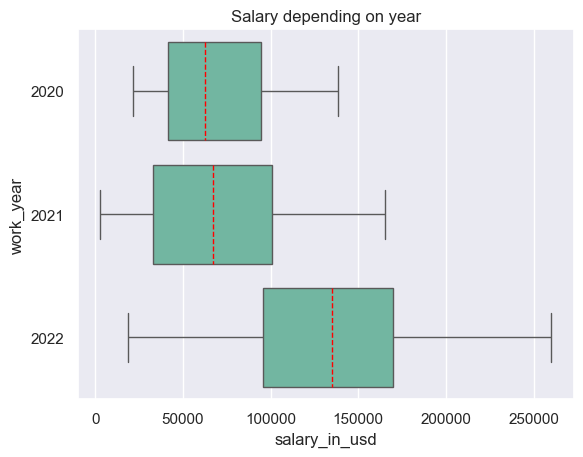

In [646]:
ax = sns.boxplot(data_DS, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='salary_in_usd', ylabel='work_year')
plt.title('Salary depending on year')
plt.show()

### 2. Анализ влияния размера компании (company_size) на зарплату специалиста Data Scientist

In [627]:
data_agg_company_size = data_DS.groupby('company_size')['salary_in_usd'].describe().round(2)
data_agg_company_size

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,42.0,95380.17,55756.89,13400.0,42860.75,89694.0,133750.0,215300.0
M,66.0,120080.58,56347.79,4000.0,80000.00,119529.5,157500.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.00,49268.0,82500.0,105000.0


Как видно, что средний уровень заработной платы у компании среднего размеры, больше чем у крупной, но их и больше по количеству. Посмотрим график.

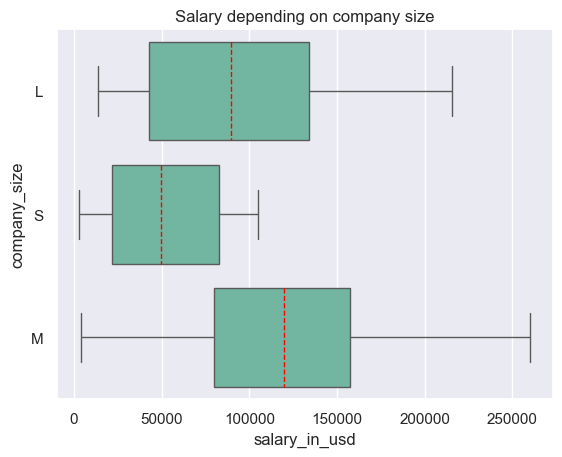

In [647]:
ax = sns.boxplot(data_DS, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='salary_in_usd', ylabel='company_size')
plt.title('Salary depending on company size')
plt.show()

### 3. Анализ влияния опыта работы (experience_level) на зарплату специалиста Data Scientist     

In [629]:
data_agg_experience_level = data_DS.groupby('experience_level')['salary_in_usd'].describe().round(2)
data_agg_experience_level

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
SE,48.0,145267.33,50597.67,20171.0,104843.0,142200.0,180000.00,260000.0


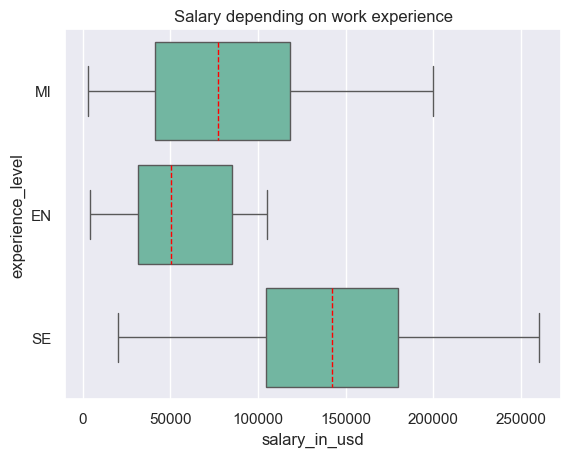

In [648]:
ax = sns.boxplot(data_DS, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='salary_in_usd', ylabel='experience_level')
plt.title('Salary depending on work experience')
plt.show()

Видно, что с увеличением опыта, уровень заработной платы также увеличивается

### 4. Анализ влияния типа трудоустройства (employment_type) на зарплату специалиста Data Scientist

In [631]:
data_agg_employment_type = data_DS.groupby('employment_type')['salary_in_usd'].describe().round(2)
data_agg_employment_type

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,126.0,101587.75,58343.68,2859.0,50330.25,99680.0,140400.00,260000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Как видно из полученного анализа, для специалиста Data Scientist для сстатистического анализа имеем только тип трудоустройства FT (полный рабочий день). Имеющимися значениями для FL (фриланс) и  PT (неполный рабочий день) следует пренебречь ввиду абсолютнго малого количества такиих данных. Посмотрим график. 

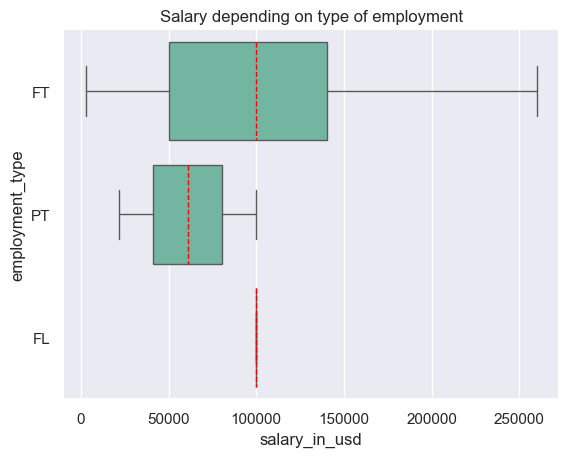

In [649]:
ax = sns.boxplot(data_DS, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='salary_in_usd', ylabel='employment_type')
plt.title('Salary depending on type of employment')
plt.show()

### 5. Анализ влияния общего объёма работы, выполняемой удалённо (remote_ratio) на зарплату специалиста Data Scientist

In [633]:
data_agg_remote_ratio = data_DS.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
data_agg_remote_ratio

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
50,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
100,67.0,112073.87,61329.08,5679.0,60412.00,105000.0,159100.0,260000.0


Видно, что самый высокий уровень заработной платы у тех, у кого объем работы, выполняемой удаленно, составляет более 80%. Немного ниже уровень заработной платы у тех, у кого объем работы выполняемой удаленно составляет менее 20%. Те же сотруднику у кого объем работы, выполняемой удаленно составляет примерно 50% иммет в среднем меньшую заработную плату.Посмотрим график.

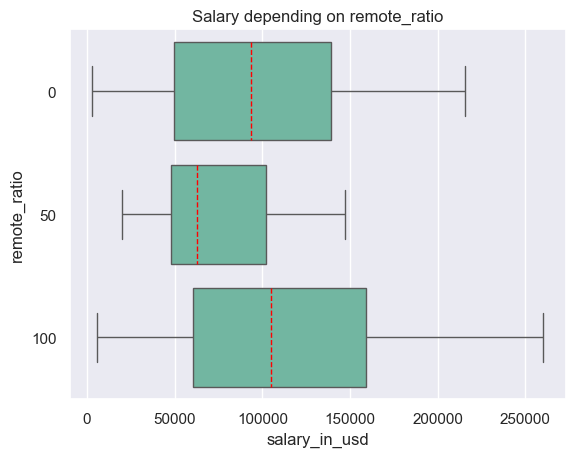

In [650]:
ax = sns.boxplot(data_DS, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='salary_in_usd', ylabel='remote_ratio')
plt.title('Salary depending on remote_ratio')
plt.show()

## Статистический анализ данных



In [635]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты года ($μ_1$) статистически меньше либо равен размеру зарплаты предыдущего года ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты года ($μ_1$) статистически больше, чем размер зарплаты предыдущего года ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [636]:
# значения salary_in_usd Data Scientist от года
salary_DS_2020 = data_DS[data_DS['work_year']==2020]['salary_in_usd']
salary_DS_2021 = data_DS[data_DS['work_year']==2021]['salary_in_usd']
salary_DS_2022 = data_DS[data_DS['work_year']==2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_DS_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_DS_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_DS_2022)
decision_normality(result[1])



Для 2020:
p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать однофакторный дисперсионный анализ ANOVA.

**Проведём тест**

In [637]:
# проводим тест
_, p = stats.f_oneway(salary_DS_2020, salary_DS_2021, salary_DS_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод
Зарплаты года увеличиваются по сравнению с предыдущим годом.

### 2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты DE ($μ_1$) статистически больше либо равен размеру зарплаты DS в 2022 году ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты DE в 2022 году ($μ_1$) статистически меньше, чем размер зарплаты DS в 2022 году ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

In [638]:
data_DE = cleaned_data_10_2[cleaned_data_10_2['job_title']=='Data Engineer']

# значения salary_in_usd по DS и DE на 2022 
salary_DS_2022 = data_DS[data_DS['work_year']==2022]['salary_in_usd']
salary_DE_2022 = data_DE[data_DE['work_year']==2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для DS:')
result = stats.shapiro(salary_DS_2022)
decision_normality(result[1])

print('Для DE:')
result = stats.shapiro(salary_DE_2022)
decision_normality(result[1])


Для DS:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE:
p-value = 0.021
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [639]:
_, p = stats.mannwhitneyu(salary_DS_2022, salary_DE_2022, alternative='less')
decision_hypothesis(p)

p-value = 0.873
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Вывод
Заработная плата у Data Engineer больше либо равна заработной плате Data Scientist

### 3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты Data Scientist не отличается  в компаниях различных размеров: небольшая компания ($μ_1$), средняя компания ($μ_2$), крупная компания ($μ_3$)
$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты Data Scientist отличается  в компаниях различных размеров: небольшая компания ($μ_1$), средняя компания ($μ_2$), крупная компания ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

In [640]:
# значения з.п. по размеру компании 
salary_DS_S = data_DS[data_DS['company_size']=='S']['salary_in_usd']
salary_DS_M = data_DS[data_DS['company_size']=='M']['salary_in_usd']
salary_DS_L = data_DS[data_DS['company_size']=='L']['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_DS_S)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_DS_M)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_DS_L)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [641]:
_, p = stats.kruskal(salary_DS_S, salary_DS_M, salary_DS_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод 
Размер заработной платы Data Scientist отличается в компаниях различного размера

### 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака Data Scientist и Data Engineer? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [642]:
#Создадим DF по интересующим вакансиям
DS_DE = cleaned_data_10_2.loc[(cleaned_data_10_2['job_title']=='Data Scientist') | (cleaned_data_10_2['job_title']=='Data Engineer')]

In [643]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(DS_DE['job_title'], DS_DE['company_size'])
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,34,80,6
Data Scientist,42,66,21


In [644]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(result[1])


p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод
Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

# Итог


При анализе имеющихся данных, а также после проведения статистических тестов, было установлено следующее:
1. На заработную плату влияют следующие факторы:
    - наблюдается ежегодный рост заработной платы в аналиируемом периоде;
    - У средних компаний, з.п. оказалась выше чем у крупных;
    - Увеличение опыта работы также ведет к увеличениию з.п.;
    - По типу занятости ответить затруднительно, т.к. по FL и PT всего 2 сотрудника, и сделать вывод будет нецелесообразно.;
    - У сотрудников, которые имели более 80% работы удаленно, самая высокая ср. з.п., в то время как у сотрудников с 50%, мин. з.п. выше всех.
2. После проведения статистических тестов были подтверждены выводы полученные в ходе анализа, а также получены ответы на другие вопросы.
### В целом, можно сказать, что почти все факторы, указаные в выборке оказывают влияние на рост з.п. и могут быть рассмотрены. 